In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import bbox_visualizer as bbv
import matplotlib.pyplot as plt
from PIL import __version__ as PILLOW_VERSION
from torchvision import datasets
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import bbox_visualizer as bbv

In [3]:
DATA_ROOT = "./data/raw/HW1_dataset/"

In [4]:
with open(os.path.join(DATA_ROOT, "classes.names"), "r") as f:
    classes_encoding = {name.strip("\n"): i for i, name in enumerate(f.readlines())}

classes_encoding

FileNotFoundError: [Errno 2] No such file or directory: './data/raw/HW1_dataset/classes.names'

### Get Labels

In [11]:
# sanity check for missing labels
bbox_labels = {name.split(".")[0] for name in os.listdir(os.path.join(DATA_ROOT, "bboxes_labels"))}
_images = {name.split(".")[0] for name in os.listdir(os.path.join(DATA_ROOT, "images"))}
missing_labels = bbox_labels.symmetric_difference(_images)
print(missing_labels)

{'P040_balloon1_956', 'P017_balloon1_1551', 'P038_tissue1_889'}


In [12]:
# remove files without labels
image_filenames = [filename for filename in os.listdir(os.path.join(DATA_ROOT, "images")) if filename.split(".")[0] not in missing_labels]
label_filenames = os.listdir(os.path.join(DATA_ROOT, "bboxes_labels"))

# sanity check that order is maintained
for label_filename, image_filename in zip(label_filenames, image_filenames):
    label_filename, image_filename = label_filename.split(".")[0], image_filename.split(".")[0]
    if label_filename != image_filename:
        print(label_filename, image_filename)
        break

In [13]:
def reverse_transform_format(label, w_img, h_img):
    cls, x_center, y_center, w, h, = label
    w_box = w * w_img
    h_box = h * h_img
    x_min = x_center * w_img - w_box / 2
    x_max = x_center * w_img + w_box / 2
    y_min = y_center * h_img - h_box / 2
    y_max = y_center * h_img + h_box / 2
    return [cls, x_min, y_min, x_max, y_max]


class ImageBBoxDataset(Dataset):
    """ This assumes that all images are of the same size """

    def __init__(self, root=DATA_ROOT, label_folder="bboxes_labels", image_folder="images", labels=label_filenames, images=image_filenames,
                 transform=None, invert_darknet=True):
        if len(images) != len(labels):
            raise RuntimeError("labels and images count dont match")
        self.root = root
        self.label_folder = label_folder
        self.image_folder = image_folder
        self.label_filenames = labels
        self.images = images
        self.labels = []
        self.transform = transform
        self.invert = invert_darknet

        temp_img = Image.open(os.path.join(self.root, self.image_folder, self.images[0]))
        self.w_img, self.h_img = temp_img.size

        for label_filename in self.label_filenames:
            with open(os.path.join(self.root, self.label_folder, label_filename), "r") as f:
                lines = f.readlines()
                if self.invert:
                    bbox_label = [reverse_transform_format([int(cls), float(x), float(y), float(w), float(h)], self.w_img, self.h_img)
                                  for cls, x, y, w, h in [line.split(" ") for line in lines]]
                else:
                    bbox_label = [[int(cls), float(x), float(y), float(w), float(h)] for cls, x, y, w, h in [line.split(" ") for line in lines]]
                self.labels.append(bbox_label)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.image_folder, self.images[index])
        x = cv.imread(image_path)[..., ::-1]
        y = self.labels[index]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.images)

    def get_paths(self, index):
        image_path = os.path.join(self.root, self.image_folder, self.images[index])
        label_path = os.path.join(self.root, self.label_folder, self.label_filenames[index])
        return image_path, label_path

ds = ImageBBoxDataset()

In [14]:
frame, boxes = ds[0]
boxes = [[round(coord) for coord in box[1:]] for box in boxes]
frame = bbv.draw_multiple_rectangles(frame, boxes,bbox_color=(255,0,0))
cv.imshow('Frame', frame)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

-1

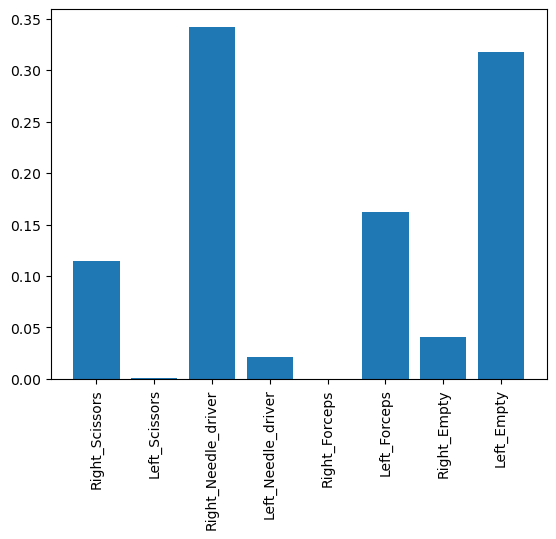

In [15]:
def count_labels(dataset, classes):
    counter = {c: 0 for c in classes}
    for _, labels in dataset:
        for label in labels:
            counter[label[0]] += 1
    return counter

counts = count_labels(ds, classes_encoding.values())
total = sum(counts.values())
plt.bar(range(len(counts)), [v / total for v in counts.values()], align='center')
plt.xticks(range(len(counts)), list(classes_encoding.keys()), rotation=90)
plt.show()

In [ ]:
counts

In [5]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\user/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-12-3 Python-3.9.15 torch-1.13.0 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [22]:
import shutil

def split_dataset(ds):
    train_idx = np.random.choice(range(len(ds)), round(0.8 * len(ds)))
    for i in range(len(ds)):
        img_path, label_path = ds.get_paths(i)
        if i in train_idx:
            dest_img = "./data/images/training"
            dest_label = "./data/labels/training"
        else:
            dest_img = "./data/images/validation"
            dest_label = "./data/labels/validation"
        shutil.copy2(img_path, dest_img)
        shutil.copy2(label_path, dest_label)

# ds_no_inverse = ImageBBoxDataset(invert_darknet=False)
# split_dataset(ds_no_inverse)

In [11]:
!python train.py --img 640 --batch 20 --epochs 1000 --device "cuda:0" --data dataset.yaml --weights yolov5s.pt

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=1000, batch_size=20, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=cuda:0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5  2022-12-5 Python-3.9.15 torch-1.13.0 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, persp

In [ ]:
! jupyter notebook --NotebookApp.iopub_data_rate_limit=1e12

In [ ]:
!python train.py --img 640 --batch 20 --epochs 1000 --device "cuda:0" --data dataset.yaml --weights '' --cfg yolov5s.yaml